GOAL: get same results as nnUNet: DC=0.92 (LV) DC=0.84 (MYO) on the test. Here you implement nnUnet architecture and UNet architecture with the possibility to use spatial and intensity based data augm. 

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F
from matplotlib.backends.backend_pdf import PdfPages
import os 
import pandas as pd
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from albumentations.augmentations.transforms import HorizontalFlip, VerticalFlip, Rotate, RandomScale, GaussNoise, RandomGamma, RandomBrightnessContrast, Resize, ElasticTransform, GaussianBlur
import re
import cv2
from skimage import measure, exposure
import torchvision

Prepare paths to read the data:

In [2]:
def load_nii(path): 
    data = nib.load(path)
    return data.get_fdata()

In [3]:
data_path_train = '/home/carla/Desktop/euCanSHare/Datasets/training/training_VH'
listdir_train = os.listdir(data_path_train)
df_train = pd.DataFrame({'patient': listdir_train})
df_train = df_train[:2]
df_train.shape

(2, 1)

In [4]:
data_path_val = '/home/carla/Desktop/euCanSHare/Datasets/validation/validation_VH'
listdir_val = os.listdir(data_path_val)
df_val = pd.DataFrame({'patient': listdir_val})
df_val = df_val[:1]
df_val.shape

(1, 1)

In [5]:
data_path_test = '/home/carla/Desktop/euCanSHare/Datasets/testing/testing_STPAU'
listdir_test = os.listdir(data_path_test)
df_test = pd.DataFrame({'patient': listdir_test})
df_test.shape

(15, 1)

In [6]:
imgs_path_train = [d + '/' + 'patient' + re.findall(r'\d+', d)[0] + '_LGE.nii.gz' for d in df_train.patient]
masks_path_train = [d + '/' + 'patient' + re.findall(r'\d+', d)[0] + '_LGE_gt.nii.gz' for d in df_train.patient]

In [7]:
imgs_path_val = [d + '/' + 'patient' + re.findall(r'\d+', d)[0] + '_LGE.nii.gz' for d in df_val.patient]
masks_path_val = [d + '/' + 'patient' + re.findall(r'\d+', d)[0] + '_LGE_gt.nii.gz' for d in df_val.patient]

In [8]:
imgs_path_test = [d + '/' + 'patient' + re.findall(r'\d+', d)[0] + '_LGE.nii.gz' for d in df_test.patient]
masks_path_test = [d + '/' + 'patient' + re.findall(r'\d+', d)[0] + '_LGE_gt.nii.gz' for d in df_test.patient]

Read data and save each slice as .npy file so that it is faster to load during training:

In [9]:
def generate_slices(data_path, df_path, imgs_path, masks_path): 
    
    for ix, p in enumerate (tqdm(df_path.patient)): 
        if "VH" in imgs_path[ix] or "STPAU" in imgs_path[ix]:
            v_lge = load_nii('{}/{}'.format(data_path, imgs_path[ix]))[:,:,:,0]
            v_gt = load_nii('{}/{}'.format(data_path, masks_path[ix]))[:,:,:,0]
        else: 
            v_lge = load_nii('{}/{}'.format(data_path, imgs_path[ix]))
            v_gt = load_nii('{}/{}'.format(data_path, masks_path[ix]))
            
        img_folder = '{}/{}/img_slices'.format(data_path, p)
        if not os.path.exists(img_folder): 
            os.mkdir(img_folder)
        channels = v_lge.shape[2]
        for c in range (channels):
            img = v_lge[:, :, c]
            if img.shape[0] < img.shape[1]: #rotation of the image, so that all have a similar size (.shape[0] > .shape[1])
                img = np.rot90(img)  
            np.save('{}/img_{}'.format(img_folder,c) + '.npy', img)

        mask_folder = '{}/{}/gt_slices'.format(data_path, p)
        if not os.path.exists(mask_folder): 
            os.mkdir(mask_folder)
        channels = v_gt.shape[2]
        for c in range (channels):
            gt = np.array(v_gt[:, :, c], dtype=np.uint8)
            if gt.shape[0] < gt.shape[1]:
                gt = np.rot90(gt)
            np.save('{}/gt_{}'.format(mask_folder,c) + '.npy', gt)

In [10]:
generate_slices(data_path_train, df_train, imgs_path_train, masks_path_train)

100%|██████████| 2/2 [00:00<00:00, 45.69it/s]


In [11]:
generate_slices(data_path_val, df_val, imgs_path_val, masks_path_val)

100%|██████████| 1/1 [00:00<00:00, 63.04it/s]


In [12]:
generate_slices(data_path_test, df_test, imgs_path_test, masks_path_test)

100%|██████████| 15/15 [00:00<00:00, 18.73it/s]


In [13]:
len(df_train), len(df_val), len(df_test)

(2, 1, 15)

Define paths to call folder with .npy slices

In [14]:
img_path_train = [d + '/img_slices' for d in df_train.patient]
gt_path_train = [d + '/gt_slices' for d in df_train.patient]

img_path_val = [d + '/img_slices' for d in df_val.patient]
gt_path_val = [d + '/gt_slices' for d in df_val.patient]
 
img_path_test = [d + '/img_slices' for d in df_test.patient]
gt_path_test = [d + '/gt_slices' for d in df_test.patient]

5
(256, 256) float64 90.0 0.0
(256, 256) uint8 2 0


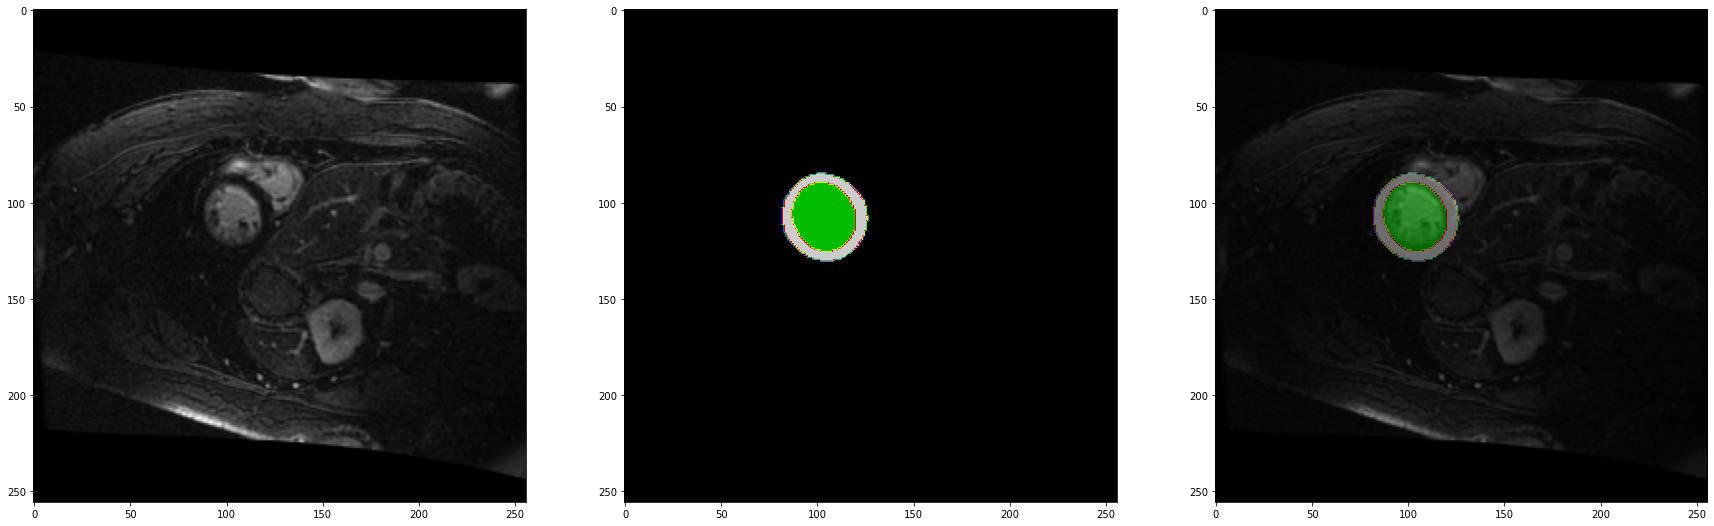

In [15]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(30,10))
ix = random.randint(0, len(gt_path_train)-1)
channel = random.randint(0, 5)
img = np.load('{}/{}/img_{}.npy'.format(data_path_train, img_path_train[ix], channel))
gt = np.load('{}/{}/gt_{}.npy'.format(data_path_train, gt_path_train[ix], channel))
ax1.imshow(img[:,:], cmap='gist_gray')
ax2.imshow(gt[:,:], cmap='nipy_spectral')
ax3.imshow(img[:,:], cmap='gist_gray')
ax3.imshow(gt[:,:], alpha=0.5, cmap='nipy_spectral')

print(channel)
print(img.shape, img.dtype, img.max(), img.min())
print(gt.shape, gt.dtype, gt.max(), gt.min())

In [16]:
#RandomCropping

def get_random_crop_coords(height, width, crop_height, crop_width, h_start, w_start):
    y1 = int((height - crop_height) * h_start)
    y2 = y1 + crop_height
    x1 = int((width - crop_width) * w_start)
    x2 = x1 + crop_width
    return x1, y1, x2, y2

def random_crop(img, gt, crop_height, crop_width):
    height, width = img.shape[:2]
    case = 0
    
    if height <= 256 and width >= 256: #crop width
        crop = 256
        x1 = (width - crop) // 2
        x2 = x1 + crop
        y1 = 0
        y2 = height
        case = 1
    
    if height >= 256 and width <= 256:  #crop height
        crop = 256
        y1 = (height - crop) // 2
        y2 = y1 + crop 
        x1 = 0
        x2 = width
        case = 2
        
    if height >= 256 and width >= 256: #crop both 
        h_start = random.random()
        w_start = random.random()
        x1, y1, x2, y2 = get_random_crop_coords(height, width, crop_height, crop_width, h_start, w_start)
        case = 3
    
    if height <= 256 and width <= 256: #crop none of them
        case = 4

    sum_MYO_LV = gt.sum() #make sure the gt is not removed
    count = 0
    while True:
        if case == 1: 
            y1 = 0
            y2 = height
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        if case == 2: 
            x1 = 0
            x2 = width 
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        if case == 3: 
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        else: 
            img_cropped = img
            gt_cropped = gt
        
        if gt_cropped.sum() == sum_MYO_LV: #gt is not removed
            break
        
        #gt is removed
        
        if count<15: #try 14 times random coordinates      
            h_start = random.random()
            w_start = random.random()
            x1, y1, x2, y2 = get_random_crop_coords(height, width, crop_height, crop_width, h_start, w_start)     
        if count == 15: #after 14 attempts try to use center coordinates  
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)
        if count > 15 and count < 45: 
            x1 += 10
            x2 -= 10
        if count == 45: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)
        if count > 45 and count < 75: 
            x2 += 10
            x1 -= 10
        if count == 75: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)            
        if count > 75 and count < 105: 
            y1 += 10
            y2 -= 10
        if count == 105: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width) 
        if count > 105:
            y2 += 10
            y1 -= 10
        if count == 135: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)            
        if count > 135:
            y2 += 10
            y1 -= 10
            x2 += 10
            x1 -= 10
        if count == 165: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)            
        if count > 165:
            y2 += 10
            y1 -= 10
            x2 -= 10
            x1 += 10
        if count == 195: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)            
        if count > 195:
            y2 -= 10
            y1 += 10
            x2 -= 10
            x1 += 10
        if count == 225: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)            
        if count > 225:
            y2 -= 10
            y1 += 10
            x2 += 10
            x1 -= 10
            print('I am removing groundtruth...')
            print(case)
        count += 1
    
    if img_cropped.shape[0] != 256 or img_cropped.shape[1] != 256: #if the size is not the desired one resize
        resize = Resize(256, 256)
        img_cropped = resize(image=img_cropped)['image']
        gt_cropped = resize(image=gt_cropped)['image']
               
    return img_cropped, gt_cropped

In [17]:
#CenterCropping 

def get_center_crop_coords(height, width, crop_height, crop_width):
    y1 = (height - crop_height) // 2
    y2 = y1 + crop_height
    x1 = (width - crop_width) // 2
    x2 = x1 + crop_width
    return x1, y1, x2, y2

def center_crop(img, gt, crop_height, crop_width):     
    height, width = img.shape[:2]
    case = 0
    
    if height <= 256 and width >= 256: #crop width
        crop = 256
        x1 = (width - crop) // 2
        x2 = x1 + crop
        y1 = 0
        y2 = height
        case = 1
    
    if height >= 256 and width <= 256: #crop height
        crop = 256
        y1 = (height - crop) // 2
        y2 = y1 + crop 
        x1 = 0
        x2 = width
        case = 2
    
    if height >= 256 and width >= 256: #crop both 
        x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)
        case = 3
    
    if height <= 256 and width <= 256: #crop none of them
        case = 4
    
    sum_MYO_LV = gt.sum() #make sure the gt is not removed
    count = 0
    while True:
        if case == 1: 
            y1 = 0
            y2 = height
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        if case == 2: 
            x1 = 0
            x2 = width 
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        if case == 3: 
            img_cropped = img[y1:y2, x1:x2]
            gt_cropped = gt[y1:y2, x1:x2]
        else: 
            img_cropped = img
            gt_cropped = gt
        
        if gt_cropped.sum() == sum_MYO_LV: #gt is not removed
            break
                     
        if count<15: #try 14 times random coordinates      
            pass
        if count == 15: #after 14 attempts try to use center coordinates  
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)
        if count > 15 and count < 45: 
            x1 += 10
            x2 -= 10
        if count == 45: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)
        if count > 45 and count < 75: 
            x2 += 10
            x1 -= 10
        if count == 75: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)            
        if count > 75 and count < 105: 
            y1 += 10
            y2 -= 10
        if count == 105: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width) 
        if count > 105:
            y2 += 10
            y1 -= 10
        if count == 135: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)            
        if count > 135:
            y2 += 10
            y1 -= 10
            x2 += 10
            x1 -= 10
        if count == 165: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)            
        if count > 165:
            y2 += 10
            y1 -= 10
            x2 -= 10
            x1 += 10
        if count == 195: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)            
        if count > 195:
            y2 -= 10
            y1 += 10
            x2 -= 10
            x1 += 10
        if count == 225: 
            x1, y1, x2, y2 = get_center_crop_coords(height, width, crop_height, crop_width)            
        if count > 225:
            y2 -= 10
            y1 += 10
            x2 += 10
            x1 -= 10
            print('I am removing groundtruth...')
            print(case)
        count += 1
    
    if img_cropped.shape[0] != 256 or img_cropped.shape[1] != 256: #if the size is not the desired one resize
        resize = Resize(256, 256)
        img_cropped = resize(image=img_cropped)['image']
        gt_cropped = resize(image=gt_cropped)['image']
    
     
    return img_cropped, gt_cropped

In [18]:
#Inverse Gamma function

def gamma_inverse(img, gamma_limit):
    gamma = random.randint(gamma_limit[0], gamma_limit[1]) / 100.0
    if img.dtype == np.uint8:
        table = (np.arange(0, 256.0 / 255, 1.0 / 255) ** (1/gamma)) * 255
        img = cv2.LUT(img, table.astype(np.uint8))
    else:
        img = np.power(img, gamma)

    return img

In [19]:
#Fill holes

def keep_largest_connected_components(mask):
    '''
    Keeps only the largest connected components of each label for a segmentation mask.
    '''

    out_img = np.zeros(mask.shape, dtype=np.uint8)

    for struc_id in [1, 2, 3]:

        binary_img = mask == struc_id
        blobs = measure.label(binary_img, connectivity=1)

        props = measure.regionprops(blobs)

        if not props:
            continue

        area = [ele.area for ele in props]
        largest_blob_ind = np.argmax(area)
        largest_blob_label = props[largest_blob_ind].label

        out_img[blobs == largest_blob_label] = struc_id

    return out_img

DataLoader is created:

In [20]:
class MRIDataset(Dataset): 
    def __init__(self, data_path, img_path, gt_path, augmentation=True, num_classes=3):
        self.data_path = data_path
        self.img_path = img_path
        self.gt_path = gt_path
        self.augmentation = augmentation
        self.num_classes = num_classes
    def __len__(self):
        return len(self.img_path) 
    def __getitem__(self, ix): #slice by slice 
                
        img = np.load('{}/{}'.format(self.data_path, self.img_path[ix]))
                
        gt = np.load('{}/{}'.format(self.data_path, self.gt_path[ix]))
                                         
        if "MSCMR" in self.img_path[ix]: 
            self.num_classes = 4 
        if "EMIDEC" in self.img_path[ix]:
            mask = img>0 #remove black background
            img = img[np.ix_(mask.any(1),mask.any(0))]
            gt = gt[np.ix_(mask.any(1),mask.any(0))]
            self.num_classes = 5
        if "VH" in self.img_path[ix]: 
            mask = img>0
            img = img[np.ix_(mask.any(1),mask.any(0))]
            gt = gt[np.ix_(mask.any(1),mask.any(0))]
        
        if self.augmentation: #default data augmentation
                
            horizontal_flip = HorizontalFlip(p=0.2)
            vertical_flip = VerticalFlip(p=0.2)
            rotation = Rotate(p=0.2, limit=[-30, 30])
            rescale = RandomScale(scale_limit=[0.63, 1.18], p=0.2) 
            
            data = horizontal_flip(image=img, mask=gt) #horizational flip
            img = data['image']
            gt = data['mask']

            data = vertical_flip(image=img, mask=gt) #vertical flip
            img = data['image']
            gt = data['mask']
            
            data = rotation(image=img, mask=gt) #rotation
            img = data['image']
            gt = data['mask'] 

            data = rescale(image=img, mask=gt) #rescaling
            img = data['image']
            gt = data['mask']
            
            [img, gt] = random_crop(img, gt, 256, 256) #cropping
        
        else: 
            [img, gt] = center_crop(img, gt, 256, 256) #cropping
            
        img = np.array((img-np.min(img))/(np.max(img)-np.min(img)), dtype=np.float32) #normalization based on max and min
               
        if self.augmentation: #intensity-based data augmentation
        
            gaussian = GaussNoise(var_limit=(0, 0.001), p=0.2)
            gamma = RandomGamma(gamma_limit=(70, 150), p=0.2)
            brightness = RandomBrightnessContrast(brightness_limit=(0.5), contrast_limit=0, p=0.2)
            contrast = RandomBrightnessContrast(brightness_limit=0, contrast_limit=(0.5), p=0.2)
            #img = img.astype('float32')
            if random.uniform(0,1) < 0.2: 
                img = cv2.bilateralFilter(img,7,75,75) #bilateral filtering
            img = gaussian(image=img)['image'] #gaussian
            img = gamma(image=img)['image'] #gamma
            
            if random.uniform(0,1) < 0.2: 
                img = gamma_inverse(img=img, gamma_limit=(70, 150)) #inverse gamma
            img = brightness(image=img)['image'] #brightness
            img = contrast(image=img)['image'] #contrast
                    
        gt = (np.arange(self.num_classes) == gt[...,None]).astype(int) #create binary gt
        
        if "MSCMR" in self.img_path[ix]:
            gt[:,:,3] = keep_largest_connected_components(gt[:,:,3])
        else:
            gt[:,:,1] = keep_largest_connected_components(gt[:,:,1])        

        if "MSCMR" in self.img_path[ix]:
            gt[:, :, 0] += gt[:, :, 1] #0:BG
            gt[:, :, 1] = gt[:, :, 2] #1:MYO
            gt[:, :, 2] = gt[:, :, 3] #2:LV
            gt = gt[:, :, 0:3] 
            
        if "EMIDEC" in self.img_path[ix]:            
            gt[:,:,3] += gt[:,:,2] #1:MYO
            gt[:,:,3] += gt[:,:,4] #1:MYO
            gt[:,:,2] = gt[:,:,1] #2:LV
            gt[:,:,1] = gt[:,:,3] #1:MYO
            gt = gt [:,:,0:3]
            
        if "VH" in self.img_path[ix] or "STPAU" in self.img_path[ix]: 
            gt_ = np.zeros((gt.shape))
            gt_[:,:,0] = gt[:,:,0] #0:BG
            gt_[:,:,1] = gt[:,:,2] #1:MYO
            gt_[:,:,2] = gt[:,:,1] #2:LV
            gt = gt_
                 
        gt[:,:,0] = np.ones((gt.shape[0], gt.shape[1])) - gt[:, :, 1] - gt[:, :, 2]
        
        #if self.augmentation: 
            #erasing = torchvision.transforms.transforms.RandomErasing(p=0.5, value=2.)
            #img_ = erasing(torch.from_numpy(img[None,...]))
            #img_ = img_.numpy()[0,:,:]
            
            #diff = img_-gt[:,:,0] 
            #if diff[diff == 2.].sum() == 0.: 
                #img_[img_==2.] = 0.
                #img = img_
                
            
        return torch.from_numpy(img).unsqueeze(0).float(), torch.from_numpy(gt.transpose((2,0,1))).float()

Define paths to call .npy slices:

In [21]:
img_train = []
gt_train = []
for patient in img_path_train:

    img_train += ['{}/{}'.format(patient,i) for i in sorted(os.listdir('{}/{}'.format(data_path_train, patient)))]

for patient in gt_path_train:

    gt_train += ['{}/{}'.format(patient,i) for i in sorted(os.listdir('{}/{}'.format(data_path_train, patient)))]

img_val = []
gt_val = []
for patient in img_path_val:

    img_val += ['{}/{}'.format(patient,i) for i in sorted(os.listdir('{}/{}'.format(data_path_val, patient)))]

for patient in gt_path_val:

    gt_val += ['{}/{}'.format(patient,i) for i in sorted(os.listdir('{}/{}'.format(data_path_val, patient)))]

img_test = []
gt_test = []
for patient in img_path_test:
    img_test += ['{}/{}'.format(patient,i) for i in sorted(os.listdir('{}/{}'.format(data_path_test, patient)))]

for patient in gt_path_test:
    gt_test += ['{}/{}'.format(patient,i) for i in sorted(os.listdir('{}/{}'.format(data_path_test, patient)))]

Define DataLoader for train, valid and test data:

In [22]:
dataset = {
    'train': MRIDataset(data_path_train, img_train, gt_train, augmentation=True),
    'val': MRIDataset(data_path_val, img_val, gt_val, augmentation=False), 
    'test': MRIDataset(data_path_test, img_test, gt_test, augmentation=False),
}

len(dataset['train']), len(dataset['val']), len(dataset['test'])

(23, 9, 308)

torch.Size([1, 256, 256]) torch.float32 tensor(1.) tensor(0.0625)
torch.Size([3, 256, 256]) torch.float32 tensor(1.) tensor(0.) True


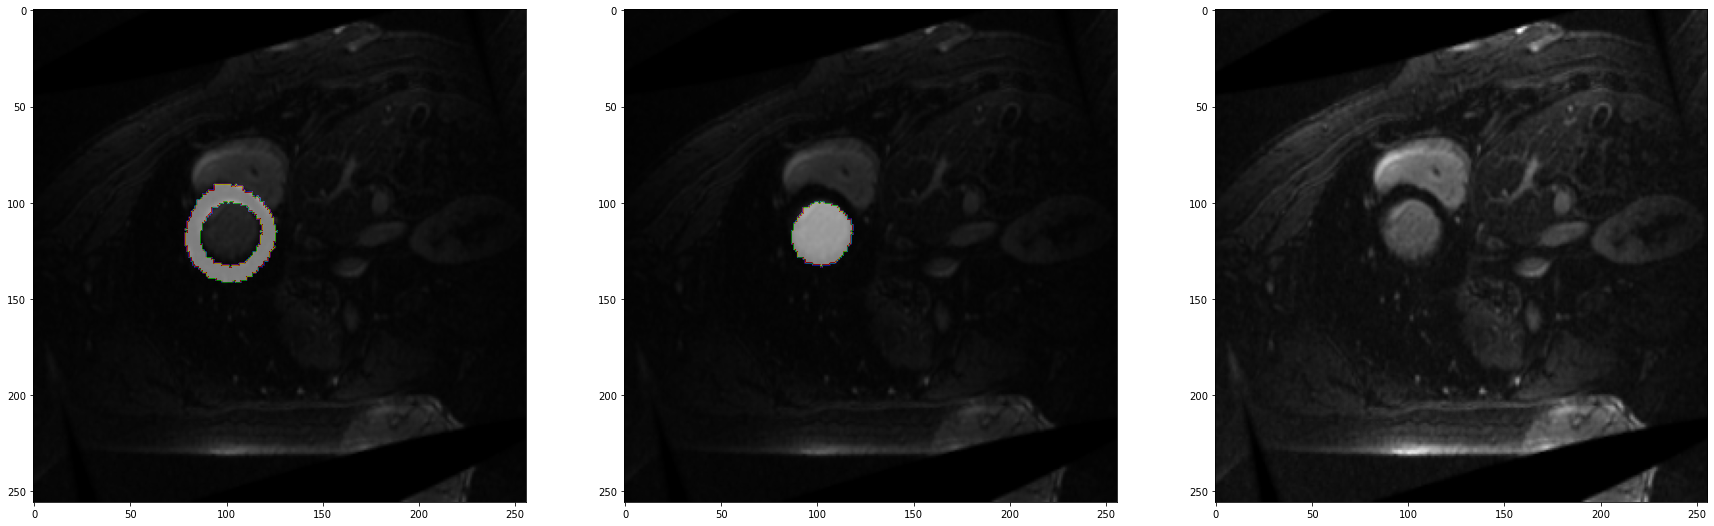

In [23]:
ds = dataset['train']
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(30,10))
ix = random.randint(0, len(ds)-1)
img, gt = ds[ix]
print(img.shape, img.dtype, img.max(), img.min())
print(gt.shape, gt.dtype, gt.max
      (), gt.min(), gt.sum().item() == gt.shape[1]*gt.shape[2])
_img = img.numpy().transpose((1,2,0))
ax1.imshow(_img[:, :, 0].squeeze(), cmap='gist_gray') 
ax2.imshow(_img[:, :, 0].squeeze(), cmap='gist_gray')
ax3.imshow(_img[:, :, 0].squeeze(), cmap='gist_gray')
_gt = gt.numpy().transpose((1,2,0))
ax1.imshow(_gt[:,:,1], alpha=0.6, cmap='nipy_spectral')
ax2.imshow(_gt[:,:,2], alpha=0.6, cmap='nipy_spectral')

Define batch size for each DataLoader:

In [24]:
bs = 16
dataloader = {
    'train': DataLoader(dataset['train'], batch_size=bs, shuffle=True, num_workers=4),
    'val': DataLoader(dataset['val'], batch_size=1, shuffle=False, num_workers=4), 
    'test': DataLoader(dataset['test'], batch_size=1, shuffle=False, num_workers=1),
}

count = 0
reference = 0

for img, gt in tqdm(dataloader['train'], ascii=True): 
    reference += img.sum(axis=0)[0,:,:]
    count+=1
reference = reference/count
np.save('../../Reference/ref_EMIDEC.npy'.format(ix), reference)

reference = 0
for i in range(df_train.shape[0]):
    num_patient = (re.findall(r'\d+', df_train['patient'][i])[0])  
    vol = load_nii('/home/carla/Desktop/euCanSHare/Datasets/training/training_VH/patient'+str(num_patient)+'_VH/patient'+str(num_patient)+'_LGE_post.nii.gz')
    count = 0
    reference_=0
    for j in range (vol.shape[2]):
        reference_ += vol[:,:,j]
        count+=1
    reference+=reference_/vol.shape[2]
reference = reference/df_train.shape[0]
np.save('../../Reference/ref_VH_post16.npy', reference)

reference = 0
for i in range(df_train.shape[0]):
    num_patient = (re.findall(r'\d+', df_train['patient'][i])[0])  
    vol = load_nii('/home/carla/Desktop/euCanSHare/Datasets/training/training_STPAU/patient'+str(num_patient)+'_STPAU/patient'+str(num_patient)+'_LGE_post.nii.gz')
    count = 0
    reference_=0
    for j in range (vol.shape[2]):
        reference_ += vol[:,:,j]
        count+=1
    reference=reference_/vol.shape[2]
    np.save('../../Reference/ref_STPAU_'+str(num_patient)+'.npy', reference)

img_reference = load_nii('/home/carla/Desktop/euCanSHare/Datasets/training/training_EMIDEC/patient36_EMIDEC/patient36_LGE_post.nii.gz')
template = 0
for i in range(img_reference.shape[2]): 
    template+=img_reference[:,:,i]
template = template/img_reference.shape[2]
np.save('../../Reference/ref_EMIDEC_36.npy', template)

Model:

In [25]:
class DoubleConvNN(nn.Module):

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.InstanceNorm2d(out_channels),
            nn.LeakyReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)     

class UpsampleNN(nn.Module):

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        self.upsample = nn.ConvTranspose2d(in_channels , out_channels, kernel_size=3, stride=2)
        self.conv = DoubleConvNN(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x) 

class nnUNet(nn.Module):
    def __init__(self, num_labels): 
        super().__init__()

        self.inconv = DoubleConvNN(1, 32)

        self.maxpool1 = nn.MaxPool2d(2)
        self.conv1 = DoubleConvNN(32, 64)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv2 = DoubleConvNN(64, 128)
        self.maxpool3 = nn.MaxPool2d(2)
        self.conv3 = DoubleConvNN(128, 256)
        self.maxpool4 = nn.MaxPool2d(2)
        self.conv4 = DoubleConvNN(256, 512)
        self.maxpool5 = nn.MaxPool2d(2)
        self.conv5 = DoubleConvNN(512, 1024)
        
        self.upsample1 = UpsampleNN(1024, 512)
        self.upsample2 = UpsampleNN(512, 256)
        self.upsample3 = UpsampleNN(256, 128)
        self.upsample4 = UpsampleNN(128, 64)
        self.upsample5 = UpsampleNN(64, 32)

        self.outconv = nn.Conv2d(32, num_labels, kernel_size=1)

        self.deep_conv1 = nn.Conv2d(512, num_labels, kernel_size=1)
        self.deep_conv2 = nn.Conv2d(256, num_labels, kernel_size=1)
        self.deep_conv3 = nn.Conv2d(128, num_labels, kernel_size=1)
        self.deep_conv4 = nn.Conv2d(64, num_labels, kernel_size=1)

        self.deep_deconv = nn.ConvTranspose2d(num_labels, num_labels, kernel_size=3, stride=2)

    def forward(self, x):
        x1 = self.inconv(x)

        x2 = self.maxpool1(x1)
        x2 = self.conv1(x2)
        x3 = self.maxpool2(x2)
        x3 = self.conv2(x3)
        x4 = self.maxpool3(x3)
        x4 = self.conv3(x4)
        x5 = self.maxpool4(x4)
        x5 = self.conv4(x5)
        x6 = self.maxpool5(x5)
        x6 = self.conv5(x6)

        x  = self.upsample1(x6, x5)
        x_ = self.deep_conv1(x)
        x1_deep = self.deep_deconv(x_)
        
        x = self.upsample2(x, x4)
        x_ = self.deep_conv2(x)
        diffY = x_.size()[2] - x1_deep.size()[2]
        diffX = x_.size()[3] - x1_deep.size()[3]
        x1_deep = F.pad(x1_deep, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x_ = torch.add(x1_deep, x_)
        x2_deep = self.deep_deconv(x_)

        x = self.upsample3(x, x3)
        x_ = self.deep_conv3(x)
        diffY = x_.size()[2] - x2_deep.size()[2]
        diffX = x_.size()[3] - x2_deep.size()[3]
        x2_deep = F.pad(x2_deep, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x_ = torch.add(x2_deep, x_)
        x3_deep = self.deep_deconv(x_)

        x = self.upsample4(x, x2)     
        x_ = self.deep_conv4(x)
        diffY = x_.size()[2] - x3_deep.size()[2]
        diffX = x_.size()[3] - x3_deep.size()[3]
        x3_deep = F.pad(x3_deep, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])
        x_ = torch.add(x3_deep, x_)
        x4_deep = self.deep_deconv(x_)

        x = self.upsample5(x, x1)

        x = self.outconv(x)

        diffY = x.size()[2] - x4_deep.size()[2]
        diffX = x.size()[3] - x4_deep.size()[3]
        x4_deep = F.pad(x4_deep, [diffX // 2, diffX - diffX // 2,
                      diffY // 2, diffY - diffY // 2])

        x = torch.add(x4_deep, x)
        return x

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = nnUNet(num_labels=3)

model.load_state_dict(torch.load('../../Models/state_dict_AB_DA_48.pth')['model_state_dict'])

<All keys matched successfully>

In [27]:
count = 0
for child in model.children():
    count+=1
    print('child '+str(count)+':')
    print(child)

child 1:
DoubleConvNN(
  (double_conv): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (5): LeakyReLU(negative_slope=0.01, inplace=True)
  )
)
child 2:
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
child 3:
DoubleConvNN(
  (double_conv): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): LeakyReLU(negative_slope=0.01, inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=Fal

In [28]:
ct = 0
for child in model.children():
    ct += 1
    if ct > 10:
        for param in child.parameters():
            param.requires_grad = False

In [29]:
class DiceBCELoss(nn.Module):
    def __init__(self):
        super(DiceBCELoss, self).__init__()
        self.BCE_loss = nn.BCEWithLogitsLoss()

    def forward(self, outputs, target):
        smooth = 1.
        # have to use contiguous since they may from a torch.view op
        pred = torch.sigmoid(outputs)
        
        iflat = pred.contiguous().view(-1)
        tflat = target.contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        dice_loss = 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
        
        BCE = self.BCE_loss(outputs, target)
        Dice_BCE = (dice_loss + BCE)/2

        return Dice_BCE

In [30]:
criterion = DiceBCELoss() #definition of loss

In [31]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) #definition of optimizer
model.to(device)

nnUNet(
  (inconv): DoubleConvNN(
    (double_conv): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (5): LeakyReLU(negative_slope=0.01, inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): DoubleConvNN(
    (double_conv): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): LeakyReLU(negative_slope=0.01, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): Instan

In [32]:
def dice_batch_multiclass(outputs, target, numpy=False): #metric definition
    smooth = 1.
    
    if numpy: #input is a numpy and by subject
        #flatten label and prediction tensors
        
        iflat = outputs[:,:,:,1].reshape(-1)
        tflat = target[:,:,:,1].reshape(-1)
        intersection = (iflat * tflat).sum()
        A_sum = np.sum(iflat * iflat)
        B_sum = np.sum(tflat * tflat)
        dice_1 = ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
        
        iflat = outputs[:,:,:,2].reshape(-1)
        tflat = target[:,:,:,2].reshape(-1)
        intersection = (iflat * tflat).sum()
        A_sum = np.sum(iflat * iflat)
        B_sum = np.sum(tflat * tflat)
        dice_2 = ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
        
        
    else: #input is a tensor
        
        # have to use contiguous since they may from a torch.view op
        pred = torch.sigmoid(outputs)
        
        iflat = pred[:,1,:,:].contiguous().view(-1)
        tflat = target[:,1,:,:].contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        dice_1 = ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
        
        iflat = pred[:,2,:,:].contiguous().view(-1)
        tflat = target[:,2,:,:].contiguous().view(-1)
        intersection = (iflat * tflat).sum()
        A_sum = torch.sum(iflat * iflat)
        B_sum = torch.sum(tflat * tflat)
        dice_2 = ((2. * intersection + smooth) / (A_sum + B_sum + smooth))
        
    return dice_1, dice_2

In [33]:
epochs = 600
losses_train_epochs = []
losses_val_epochs = []
dcs_lv_epochs = []
dcs_myo_epochs = []
dc_max = 0
for epoch in range(epochs):
    model.train()
    losses_train = []
    for img, gt in tqdm(dataloader['train'], ascii=True): 
        optimizer.zero_grad()
        output = model(img.to(device))
        loss = criterion(output, gt.to(device))
        losses_train.append(loss.item())
        loss.backward()
        optimizer.step()
    losses_train_epochs.append(np.mean(losses_train))
    model.eval()
    losses_val = []
    dcs_lv = []
    dcs_myo = []
    for img, gt in tqdm(dataloader['val'], ascii=True):
        pred = model(img.to(device))
        loss = criterion(pred, gt.to(device))
        losses_val.append(loss.item())
        (dc_myo, dc_lv) = dice_batch_multiclass(pred.detach().cpu(), gt.detach().cpu())
        dcs_lv.append(dc_lv)
        dcs_myo.append(dc_myo)
    dc_mean = np.mean([np.mean(dcs_lv), np.mean(dcs_myo)])
    if dc_max < dc_mean:
        dc_max = dc_mean
        torch.save({'model_state_dict': model.state_dict()}, "../../Models/state_dict.pth")
    dcs_lv_epochs.append(np.mean(dcs_lv))
    dcs_myo_epochs.append(np.mean(dcs_myo))
    losses_val_epochs.append(np.mean(losses_val))
    print('Epoch: {}. Train Loss: {:.5f}. Val Loss: {:.5f}. Val DC LV: {:.5f}. Val DC MYO: {:.5f}.'.format(epoch, np.mean(losses_train), np.mean(losses_val), np.mean(dcs_lv), np.mean(dcs_myo)))

  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 0. Train Loss: 0.02092. Val Loss: 0.01675. Val DC LV: 0.52849. Val DC MYO: 0.34279.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 1. Train Loss: 0.01276. Val Loss: 0.01459. Val DC LV: 0.57612. Val DC MYO: 0.43888.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 2. Train Loss: 0.01420. Val Loss: 0.01339. Val DC LV: 0.60950. Val DC MYO: 0.48797.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 3. Train Loss: 0.01376. Val Loss: 0.01227. Val DC LV: 0.63203. Val DC MYO: 0.50829.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 4. Train Loss: 0.00892. Val Loss: 0.01127. Val DC LV: 0.64969. Val DC MYO: 0.52062.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 5. Train Loss: 0.01682. Val Loss: 0.01073. Val DC LV: 0.65313. Val DC MYO: 0.52481.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 6. Train Loss: 0.00835. Val Loss: 0.01037. Val DC LV: 0.65490. Val DC MYO: 0.52402.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 7. Train Loss: 0.00970. Val Loss: 0.00991. Val DC LV: 0.66247. Val DC MYO: 0.52303.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 8. Train Loss: 0.00471. Val Loss: 0.00951. Val DC LV: 0.67300. Val DC MYO: 0.52012.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 9. Train Loss: 0.01560. Val Loss: 0.00915. Val DC LV: 0.68638. Val DC MYO: 0.52134.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 10. Train Loss: 0.00969. Val Loss: 0.00898. Val DC LV: 0.69823. Val DC MYO: 0.52431.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 11. Train Loss: 0.00661. Val Loss: 0.00904. Val DC LV: 0.70132. Val DC MYO: 0.52464.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 12. Train Loss: 0.00885. Val Loss: 0.00932. Val DC LV: 0.69753. Val DC MYO: 0.51791.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 13. Train Loss: 0.00574. Val Loss: 0.00970. Val DC LV: 0.69293. Val DC MYO: 0.50939.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 14. Train Loss: 0.00626. Val Loss: 0.00994. Val DC LV: 0.69314. Val DC MYO: 0.50519.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 15. Train Loss: 0.01310. Val Loss: 0.00989. Val DC LV: 0.69974. Val DC MYO: 0.49847.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 16. Train Loss: 0.00977. Val Loss: 0.00977. Val DC LV: 0.70709. Val DC MYO: 0.49073.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 17. Train Loss: 0.00879. Val Loss: 0.00951. Val DC LV: 0.71720. Val DC MYO: 0.48926.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 18. Train Loss: 0.00912. Val Loss: 0.00934. Val DC LV: 0.72416. Val DC MYO: 0.48996.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 19. Train Loss: 0.00556. Val Loss: 0.00922. Val DC LV: 0.72946. Val DC MYO: 0.48844.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 20. Train Loss: 0.00917. Val Loss: 0.00911. Val DC LV: 0.73421. Val DC MYO: 0.48542.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 21. Train Loss: 0.01892. Val Loss: 0.00905. Val DC LV: 0.73735. Val DC MYO: 0.48083.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 22. Train Loss: 0.00644. Val Loss: 0.00906. Val DC LV: 0.74043. Val DC MYO: 0.47416.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 23. Train Loss: 0.01464. Val Loss: 0.00931. Val DC LV: 0.73494. Val DC MYO: 0.45796.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 24. Train Loss: 0.00901. Val Loss: 0.00959. Val DC LV: 0.72487. Val DC MYO: 0.44188.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 25. Train Loss: 0.00737. Val Loss: 0.00980. Val DC LV: 0.71769. Val DC MYO: 0.43151.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 26. Train Loss: 0.02798. Val Loss: 0.01026. Val DC LV: 0.70078. Val DC MYO: 0.40855.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 27. Train Loss: 0.00544. Val Loss: 0.01087. Val DC LV: 0.67552. Val DC MYO: 0.38121.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 28. Train Loss: 0.00578. Val Loss: 0.01123. Val DC LV: 0.66041. Val DC MYO: 0.36914.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 29. Train Loss: 0.00766. Val Loss: 0.01154. Val DC LV: 0.65071. Val DC MYO: 0.36217.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 30. Train Loss: 0.02689. Val Loss: 0.01173. Val DC LV: 0.64793. Val DC MYO: 0.36125.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 31. Train Loss: 0.01270. Val Loss: 0.01193. Val DC LV: 0.64685. Val DC MYO: 0.36067.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 32. Train Loss: 0.00656. Val Loss: 0.01201. Val DC LV: 0.64938. Val DC MYO: 0.36169.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 33. Train Loss: 0.00619. Val Loss: 0.01193. Val DC LV: 0.65872. Val DC MYO: 0.37425.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 34. Train Loss: 0.00907. Val Loss: 0.01159. Val DC LV: 0.67480. Val DC MYO: 0.39808.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 35. Train Loss: 0.01310. Val Loss: 0.01129. Val DC LV: 0.68743. Val DC MYO: 0.41730.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 36. Train Loss: 0.00655. Val Loss: 0.01096. Val DC LV: 0.70067. Val DC MYO: 0.43167.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 37. Train Loss: 0.00514. Val Loss: 0.01070. Val DC LV: 0.71092. Val DC MYO: 0.44310.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 38. Train Loss: 0.01190. Val Loss: 0.01048. Val DC LV: 0.71760. Val DC MYO: 0.44885.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 39. Train Loss: 0.00426. Val Loss: 0.01020. Val DC LV: 0.72679. Val DC MYO: 0.45711.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 40. Train Loss: 0.00616. Val Loss: 0.00985. Val DC LV: 0.73904. Val DC MYO: 0.47268.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 41. Train Loss: 0.00618. Val Loss: 0.00946. Val DC LV: 0.74983. Val DC MYO: 0.48838.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 42. Train Loss: 0.00708. Val Loss: 0.00916. Val DC LV: 0.75625. Val DC MYO: 0.49872.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 43. Train Loss: 0.00630. Val Loss: 0.00912. Val DC LV: 0.75521. Val DC MYO: 0.49435.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 44. Train Loss: 0.00661. Val Loss: 0.00917. Val DC LV: 0.75043. Val DC MYO: 0.48606.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 45. Train Loss: 0.00501. Val Loss: 0.00911. Val DC LV: 0.75070. Val DC MYO: 0.48937.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 46. Train Loss: 0.00845. Val Loss: 0.00909. Val DC LV: 0.75020. Val DC MYO: 0.49331.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 47. Train Loss: 0.00633. Val Loss: 0.00918. Val DC LV: 0.74944. Val DC MYO: 0.49347.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 48. Train Loss: 0.00652. Val Loss: 0.00925. Val DC LV: 0.75036. Val DC MYO: 0.49217.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 49. Train Loss: 0.00588. Val Loss: 0.00933. Val DC LV: 0.75003. Val DC MYO: 0.49117.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 50. Train Loss: 0.00705. Val Loss: 0.00935. Val DC LV: 0.74967. Val DC MYO: 0.49335.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 51. Train Loss: 0.00555. Val Loss: 0.00941. Val DC LV: 0.74813. Val DC MYO: 0.49600.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 52. Train Loss: 0.00668. Val Loss: 0.00957. Val DC LV: 0.74522. Val DC MYO: 0.49603.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 53. Train Loss: 0.00474. Val Loss: 0.00979. Val DC LV: 0.73892. Val DC MYO: 0.49224.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 54. Train Loss: 0.00553. Val Loss: 0.01000. Val DC LV: 0.73143. Val DC MYO: 0.48680.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 55. Train Loss: 0.00482. Val Loss: 0.01026. Val DC LV: 0.72296. Val DC MYO: 0.47876.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 56. Train Loss: 0.00591. Val Loss: 0.01045. Val DC LV: 0.71391. Val DC MYO: 0.47118.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 57. Train Loss: 0.00527. Val Loss: 0.01075. Val DC LV: 0.70089. Val DC MYO: 0.46183.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 58. Train Loss: 0.00605. Val Loss: 0.01101. Val DC LV: 0.68969. Val DC MYO: 0.45315.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 59. Train Loss: 0.00674. Val Loss: 0.01125. Val DC LV: 0.67881. Val DC MYO: 0.44291.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 60. Train Loss: 0.00654. Val Loss: 0.01151. Val DC LV: 0.66514. Val DC MYO: 0.42783.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 61. Train Loss: 0.00714. Val Loss: 0.01178. Val DC LV: 0.65189. Val DC MYO: 0.41340.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 62. Train Loss: 0.00492. Val Loss: 0.01203. Val DC LV: 0.64272. Val DC MYO: 0.40224.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 63. Train Loss: 0.00507. Val Loss: 0.01215. Val DC LV: 0.63805. Val DC MYO: 0.39638.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 64. Train Loss: 0.00567. Val Loss: 0.01152. Val DC LV: 0.66799. Val DC MYO: 0.43227.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 65. Train Loss: 0.00648. Val Loss: 0.01090. Val DC LV: 0.69451. Val DC MYO: 0.46627.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 66. Train Loss: 0.00380. Val Loss: 0.01050. Val DC LV: 0.71077. Val DC MYO: 0.48905.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 67. Train Loss: 0.00389. Val Loss: 0.01023. Val DC LV: 0.72128. Val DC MYO: 0.50534.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 68. Train Loss: 0.00455. Val Loss: 0.01010. Val DC LV: 0.72600. Val DC MYO: 0.51206.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 69. Train Loss: 0.00410. Val Loss: 0.01012. Val DC LV: 0.72566. Val DC MYO: 0.51037.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 70. Train Loss: 0.00563. Val Loss: 0.01014. Val DC LV: 0.72692. Val DC MYO: 0.50919.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 71. Train Loss: 0.00456. Val Loss: 0.01025. Val DC LV: 0.72505. Val DC MYO: 0.50362.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 72. Train Loss: 0.00537. Val Loss: 0.01044. Val DC LV: 0.72010. Val DC MYO: 0.49456.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 73. Train Loss: 0.00281. Val Loss: 0.01069. Val DC LV: 0.71263. Val DC MYO: 0.48302.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 74. Train Loss: 0.00980. Val Loss: 0.01092. Val DC LV: 0.70428. Val DC MYO: 0.46982.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 75. Train Loss: 0.00874. Val Loss: 0.01127. Val DC LV: 0.69037. Val DC MYO: 0.45118.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 76. Train Loss: 0.00580. Val Loss: 0.01159. Val DC LV: 0.67664. Val DC MYO: 0.43228.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 77. Train Loss: 0.00498. Val Loss: 0.01182. Val DC LV: 0.66705. Val DC MYO: 0.41961.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 78. Train Loss: 0.00340. Val Loss: 0.01191. Val DC LV: 0.66357. Val DC MYO: 0.41486.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 79. Train Loss: 0.00394. Val Loss: 0.01181. Val DC LV: 0.66372. Val DC MYO: 0.41619.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 80. Train Loss: 0.00556. Val Loss: 0.01156. Val DC LV: 0.67236. Val DC MYO: 0.42555.


  0%|          | 0/2 [00:00<?, ?it/s]

Epoch: 81. Train Loss: 0.00363. Val Loss: 0.01122. Val DC LV: 0.68399. Val DC MYO: 0.43942.


  0%|          | 0/2 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,15))
ax1.plot(losses_train_epochs, label='training loss')
ax1.plot(losses_val_epochs, label='validation loss')
ax2.plot(dcs_lv_epochs, label='validation DC LV')
ax2.plot(dcs_myo_epochs, label='validation DC MYO')
ax1.legend(loc='upper right')
ax2.legend(loc='upper right')

#plt.savefig("../Plots/mix.png")

In [ ]:
model.load_state_dict(torch.load('../../Models/state_dict.pth')['model_state_dict'])

Testing slice by slice:

In [ ]:
dcs_lv = []
dcs_myo = []
vols_lge = []
masks_lge = []
preds_lge = []

model.eval()
for img, gt in dataloader['test']: #get slice

    pred = model(img.to(device)) #prediction

    (dc_myo, dc_lv) = dice_batch_multiclass(pred.detach().cpu(), gt.detach().cpu()) #measure DC per slice
    dcs_lv.append(dc_lv)
    dcs_myo.append(dc_myo)

    pred = torch.sigmoid(pred.detach().cpu()).numpy() #apply sigmoid and put 1 in the class with max prob
    pred_ = np.zeros_like(pred)
    for i in range (pred.shape[2]): 
        pred_[0, pred[0, :, i, np.arange(pred.shape[3])].argmax(axis=1), i, np.arange(pred.shape[3])] = 1.

    _gt = np.zeros((gt.shape[2], gt.shape[3])) #from binary to single slice with classes: 0,1,2
    _gt = gt[0,1,:,:]==1
    _gt = _gt + (gt[0,2,:,:]==1)*2

    _pred = np.zeros((pred_.shape[2], pred_.shape[3])) #from binary to single slice with classes: 0,1,2
    _pred = pred_[0,1,:,:]==1
    _pred = _pred + (pred_[0,2,:,:]==1)*2


    masks_lge.append(_gt.numpy()) #generate gt volume with all slices
    vols_lge.append(img.squeeze(0).squeeze(0).detach().cpu().numpy()) #generate volume with all slices
    preds_lge.append(_pred) #generate prediction volume with all slices

    vols_lge_d = np.array(vols_lge) #to array
    masks_lge_d = np.array(masks_lge) #to array
    preds_lge_d = np.array(preds_lge) #to array     

print('DC LV: {:.5f}'.format(np.mean(dcs_lv)) + ' DC MYO: {:.5f}'.format(np.mean(dcs_myo))) #DC averaging by all slices

Testing by subject:

In [ ]:
dcs_lv = []
dcs_myo = []
num_c = []
last = 0
nxt = 0

for ix, subj in enumerate (df_test.patient): #by subject

    listdir_test_img = sorted(os.listdir('{}/{}'.format(data_path_test, img_path_test[ix])))

    num_c = len(listdir_test_img)

    mask_lge = np.zeros((masks_lge_d.shape[1], masks_lge_d.shape[2], num_c))
    pred_lge = np.zeros((preds_lge_d.shape[1], preds_lge_d.shape[2], num_c))

    dc_lv = []
    dc_myo = []

    preds_lge_d[last:last+num_c, :, :] = keep_largest_connected_components(preds_lge_d[last:last+num_c, :, :])

    gt = (np.arange(3) == masks_lge_d[last:last+num_c, :, :][...,None]).astype(int)
    pred = (np.arange(3) == preds_lge_d[last:last+num_c, :, :][...,None]).astype(int)

    dc_myo.append(dice_batch_multiclass(pred, gt, numpy=True)[0]) #DC measure of each slice
    dc_lv.append(dice_batch_multiclass(pred, gt, numpy=True)[1])

    nxt += num_c
    last = nxt

    dcs_myo.append(np.mean(dc_myo)) #DC measure of each subject
    dcs_lv.append(np.mean(dc_lv))

print('DC LV: {:.5f}'.format(np.mean(dcs_lv)) + ' DC MYO: {:.5f}'.format(np.mean(dcs_myo))) #DC averaging by subject

Plot of predictions by subject:

In [ ]:
last = 0
nxt = 0
figs = {}

for ix, subj in enumerate (df_test.patient):

    num_patient = int(re.findall(r'\d+', subj)[0])  
    nmask_lge = nib.load('{}/{}/{}'.format(data_path_test, subj, 'patient' + str(num_patient) + '_LGE_gt.nii.gz'))
    nvol_lge = nib.load('{}/{}/{}'.format(data_path_test, subj, 'patient' + str(num_patient) + '_LGE.nii.gz'))

    nmask_lge_data = nmask_lge.get_fdata()
    nvol_lge_data = nvol_lge.get_fdata()
    
    nvol_lge_data_ = []
    nmask_lge_data_ = []
    for i in range (nvol_lge_data.shape[2]):
        mask = nvol_lge_data[:,:,i]>0 #remove black background
        img = nvol_lge_data[:,:,i][np.ix_(mask.any(1), mask.any(0))]
        gt = nmask_lge_data[:,:,i][np.ix_(mask.any(1), mask.any(0))]
        
        [img, gt] = center_crop(img, gt, 256, 256) #cropping
        nvol_lge_data_.append(img)
        nmask_lge_data_.append(gt)
    nmask_lge_data = np.array(nmask_lge_data_).transpose(1,2,0)
        
    listdir_test_img = sorted(os.listdir('{}/{}'.format(data_path_test, img_path_test[ix])))
    num_c = len(listdir_test_img)
        
    vol_lge = np.zeros((vols_lge_d.shape[1], vols_lge_d.shape[2], num_c))
    mask_lge = np.zeros((masks_lge_d.shape[1], masks_lge_d.shape[2], num_c))
    pred_lge = np.zeros((preds_lge_d.shape[1], preds_lge_d.shape[2], num_c))
    

    for i, s in enumerate(listdir_test_img):
        num_slice = int(re.findall(r'\d+', s)[0])
        
        vol_lge[:, :, num_slice] = vols_lge_d[last+i, :, :]
        mask_lge[:, :, num_slice] = masks_lge_d[last+i, :, :]
        pred_lge[:, :, num_slice] = keep_largest_connected_components(preds_lge_d[last+i, :, :])
        
    #npred_lge_data = reverse_center_crop(pred_lge, nmask_lge_data.shape[0], nmask_lge_data.shape[1], 256, 256)
    #npred_lge = nib.Nifti1Image(npred_lge_data, nmask_lge.affine, nmask_lge.header)
    #nib.save(npred_lge, os.path.join('{}/{}'.format(data_path_test, subj), 'patient' + str(num_patient) + '_LGE_pred.nii')) #CHANGE!
    
    nxt += num_c
    false_ix = (pred_lge-mask_lge) != 0 
    false = np.zeros((pred_lge.shape))
    false[false_ix] = 1
            
    fig, ax = plt.subplots(vol_lge.shape[2], 2, figsize=(10, 100)) 
    count1 = 0
    count2 = 1
    for i, axi in enumerate(ax.flat):
        if i%2 == 0:
            if i == 0: 
                axi.set_title('prediction') 
            axi.imshow(vol_lge[:, :, i-count1], cmap='gist_gray')
            axi.imshow(pred_lge[:, :, i-count1], alpha=0.6, cmap='nipy_spectral')
            axi.imshow(false[:, :, i-count1], alpha=0.6, cmap='nipy_spectral')
            axi.set(xticks=[], yticks=[])
            axi.set_ylabel('slice ' + str(i-count1))
            count1 += 1
        else:
            if i ==1: 
                axi.set_title('groundtruth: ' + str(subj))
            axi.imshow(vol_lge[:, :, i-count2], cmap='gist_gray')
            axi.imshow(mask_lge[:, :, i-count2], alpha=0.6, cmap='nipy_spectral')
            axi.set(xticks=[], yticks=[])
            count2 += 1

    figs['fig' + str(ix)] = fig
    
    
    last = nxt   

In [ ]:
#with PdfPages('results.pdf') as pdf:
    #for ix in range(len(df_train.patient)): 
        #pdf.savefig(figs['fig' + str(ix)])